## Stock Market Data Cleaning

### CS 5805 Machine Learning

This file loads, cleans, and prepares stock market data for binary classification (Up/Down prediction) in `2_baseline_and_lstm_models.ipynb`

Dataset from: https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs

### Outputs:

data/processed/train.csv - Training set

data/processed/val.csv - Validation set

data/processed/test.csv - Test set

### 1. Setup & Configuration

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

STOCKS = [
    'aapl',  # Apple
    'msft',  # Microsoft
    'googl', # Google
    'amzn',  # Amazon
    'tsla',  # Tesla
    'jpm',   # JPMorgan
    'jnj',   # Johnson & Johnson
    'v',     # Visa
    'wmt',   # Walmart
    'pg',    # Procter & Gamble
]

# Data split ratios
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Paths
RAW_DATA_DIR = Path('../data/raw')
PROCESSED_DATA_DIR = Path('../data/processed')
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

print(f"\nSelected {len(STOCKS)} stocks: {', '.join([s.upper() for s in STOCKS])}")
print(f"Data split - Train: {TRAIN_RATIO:.0%}, Validation: {VAL_RATIO:.0%}, Test: {TEST_RATIO:.0%}")


Selected 10 stocks: AAPL, MSFT, GOOGL, AMZN, TSLA, JPM, JNJ, V, WMT, PG
Data split - Train: 70%, Validation: 15%, Test: 15%


### 2. Load Raw Stock Data

In [127]:
def load_stock_data(stock_symbol, data_dir):
    """
    Load a single stock's data from raw directory.
    
    Args:
        stock_symbol: Stock ticker (e.g. 'aapl')
        data_dir: Path to raw data directory (../data/raw)
    
    Returns:
        DataFrame with stock data or None if file not found
    """
    file_path = data_dir / f'{stock_symbol}.us.txt'
    
    if not file_path.exists():
        print(f"{stock_symbol}.us.txt not found")
        return None
    
    try:
        df = pd.read_csv(file_path)
        df['Date'] = pd.to_datetime(df['Date'])
        df['Stock'] = stock_symbol.upper()
        df = df.sort_values('Date').reset_index(drop=True)
        return df
    except Exception as e:
        print(f"Error loading {stock_symbol}: {e}")
        return None

# Load all selected stocks
print("Stock data:\n")
stock_data = {}

for stock in STOCKS:
    df = load_stock_data(stock, RAW_DATA_DIR)
    if df is not None:
        stock_data[stock] = df
        print(f"{stock.upper():6s}- {len(df):7,d} rows, {df['Date'].min().date()} to {df['Date'].max().date()}")

Stock data:

AAPL  -   8,364 rows, 1984-09-07 to 2017-11-10
MSFT  -   7,983 rows, 1986-03-13 to 2017-11-10
GOOGL -   3,333 rows, 2004-08-19 to 2017-11-10
AMZN  -   5,153 rows, 1997-05-16 to 2017-11-10
TSLA  -   1,858 rows, 2010-06-28 to 2017-11-10
JPM   -  12,074 rows, 1970-01-02 to 2017-11-10
JNJ   -  12,074 rows, 1970-01-02 to 2017-11-10
V     -   2,432 rows, 2008-03-18 to 2017-11-10
WMT   -  11,443 rows, 1972-03-20 to 2017-11-10
PG    -  12,075 rows, 1970-01-02 to 2017-11-10


### 3. Data Cleaning

In [128]:
# Check for missing values
print("Checking for missing values:\n")
for stock, df in stock_data.items():
    missing = df.isnull().sum()
    print(f"{stock.upper()}: {missing.sum()} missing values")

Checking for missing values:

AAPL: 0 missing values
MSFT: 0 missing values
GOOGL: 0 missing values
AMZN: 0 missing values
TSLA: 0 missing values
JPM: 0 missing values
JNJ: 0 missing values
V: 0 missing values
WMT: 0 missing values
PG: 0 missing values


In [129]:
# Check for duplicate dates
print("Checking for duplicate dates:\n")
for stock, df in stock_data.items():
    duplicates = df[df.duplicated(subset=['Date'], keep=False)]
    if len(duplicates) > 0:
        print(f"{stock.upper()}: {len(duplicates)} duplicate dates found")
        display(duplicates[['Date', 'Close']])
        # Remove duplicates, keeping first occurrence
        stock_data[stock] = df.drop_duplicates(subset=['Date'], keep='first').reset_index(drop=True)
        print(f"   → Removed duplicates, kept first occurrence")
    else:
        print(f"{stock.upper()}: No duplicate dates")

Checking for duplicate dates:

AAPL: No duplicate dates
MSFT: No duplicate dates
GOOGL: No duplicate dates
AMZN: No duplicate dates
TSLA: No duplicate dates
JPM: No duplicate dates
JNJ: No duplicate dates
V: No duplicate dates
WMT: No duplicate dates
PG: No duplicate dates


In [130]:
# Check for invalid prices (zero or negative)
print("Checking for zero or negative prices:\n")
for stock, df in stock_data.items():
    price_columns = ['Open', 'High', 'Low', 'Close']
    invalid_prices = df[(df[price_columns] <= 0).any(axis=1)]
    
    if len(invalid_prices) > 0:
        print(f"{stock.upper()}: {len(invalid_prices)} rows with zero or negative prices")
        display(invalid_prices[['Date'] + price_columns])
        # Option: Remove these rows or interpolate
        # stock_data[stock] = df[(df[price_columns] > 0).all(axis=1)].reset_index(drop=True)
        print(f"   → Removed {len(invalid_prices)} invalid rows")
    else:
        print(f"{stock.upper()}: All prices are positive")

Checking for zero or negative prices:

AAPL: All prices are positive
MSFT: All prices are positive
GOOGL: All prices are positive
AMZN: All prices are positive
TSLA: All prices are positive
JPM: All prices are positive
JNJ: All prices are positive
V: All prices are positive
WMT: All prices are positive
PG: All prices are positive


In [131]:
# Detect outliers using IQR method
print("Detecting outliers using IQR method:\n")

def detect_outliers_iqr(series, multiplier=3.0):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return (series < lower_bound) | (series > upper_bound)

for stock, df in stock_data.items():
    # Calculate daily returns
    df['Daily_Return'] = df['Close'].pct_change() * 100
    
    # Count outliers in daily returns
    outliers = detect_outliers_iqr(df['Daily_Return'].dropna(), multiplier=3.0)
    outlier_count = outliers.sum()
    
    if outlier_count > 0:
        print(f"{stock.upper()}: {outlier_count} outlier days detected")
        outlier_df = df[df['Daily_Return'].notna()][outliers]
        print(f"Extreme returns range: {outlier_df['Daily_Return'].min():.2f}% to {outlier_df['Daily_Return'].max():.2f}%")
        display(outlier_df[['Date', 'Close', 'Daily_Return']].head())
    else:
        print(f"{stock.upper()}: No extreme outliers detected")

print("Keep all outliers due to volatility of stock market.")

Detecting outliers using IQR method:

AAPL: 65 outlier days detected
Extreme returns range: -51.85% to 33.21%


,Date,Close,Daily_Return
125,1985-03-07,0.35344,-10.102757
787,1987-10-19,1.16790,-24.373503
789,1987-10-21,1.29590,17.403515
792,1987-10-26,0.89660,-21.150295
794,1987-10-28,1.07310,10.834538


MSFT: 129 outlier days detected
Extreme returns range: -30.01% to 19.53%


,Date,Close,Daily_Return
6,1986-03-21,0.06720,-10.792513
10,1986-03-27,0.07533,12.098214
12,1986-04-01,0.06720,-10.792513
13,1986-04-02,0.07533,12.098214
16,1986-04-07,0.06720,-10.792513


GOOGL: 48 outlier days detected
Extreme returns range: -11.61% to 19.99%


,Date,Close,Daily_Return
1,2004-08-20,54.155,7.942994
27,2004-09-28,63.430,7.272112
44,2004-10-21,74.690,6.327853
45,2004-10-22,86.215,15.430446
46,2004-10-25,93.700,8.681784


AMZN: 145 outlier days detected
Extreme returns range: -24.77% to 34.47%


,Date,Close,Daily_Return
3,1997-05-21,1.43,-12.804878
33,1997-07-03,1.91,20.125786
35,1997-07-08,2.30,15.000000
38,1997-07-11,2.29,-10.546875
40,1997-07-15,2.44,14.018692


TSLA: 21 outlier days detected
Extreme returns range: -19.33% to 40.53%


,Date,Close,Daily_Return
1,2010-06-29,23.89,40.529412
4,2010-07-02,19.20,-12.568306
5,2010-07-06,16.11,-16.093750
91,2010-11-04,24.90,14.377584
95,2010-11-10,29.36,19.204222


JPM: 152 outlier days detected
Extreme returns range: -27.69% to 25.12%


,Date,Close,Daily_Return
1267,1975-01-09,1.8087,6.897163
1319,1975-03-25,1.7254,-9.213365
3681,1984-07-27,3.3672,6.881666
4448,1987-08-11,6.5009,7.291512
4496,1987-10-19,3.8755,-27.685102


JNJ: 62 outlier days detected
Extreme returns range: -18.38% to 12.23%


,Date,Close,Daily_Return
18,1970-01-28,0.55330,-5.644611
99,1970-05-25,0.39877,-7.559460
101,1970-05-27,0.40692,6.381533
103,1970-05-29,0.43954,5.900494
115,1970-06-16,0.50440,6.834982


V: 35 outlier days detected
Extreme returns range: -13.67% to 28.42%


,Date,Close,Daily_Return
1,2008-03-19,13.424,28.422462
2,2008-03-20,15.290,13.900477
3,2008-03-24,14.190,-7.194245
29,2008-04-29,19.215,6.940116
92,2008-07-29,18.048,7.678539


WMT: 412 outlier days detected
Extreme returns range: -52.10% to 108.77%


,Date,Close,Daily_Return
4,1972-03-27,0.04251,24.919189
8,1972-04-03,0.03403,-19.948247
24,1972-05-19,0.04251,24.919189
138,1972-11-01,0.05101,19.995295
146,1972-11-15,0.04251,-16.663399


PG: 86 outlier days detected
Extreme returns range: -30.24% to 21.99%


,Date,Close,Daily_Return
93,1970-05-15,1.2103,4.915049
101,1970-05-27,1.1052,9.588498
102,1970-05-28,1.1698,5.845096
819,1973-04-02,2.3718,-6.375084
912,1973-08-14,2.5009,-6.623605


Keep all outliers due to volatility of stock market.


### 4. Exploratory Data Analysis (EDA)

In [132]:
# Display sample data
if stock_data:
    sample_stock = list(stock_data.keys())[0]
    print(f"Sample data from {sample_stock.upper()}:")
    display(stock_data[sample_stock].head())
    print(f"Data types:")
    display(stock_data[sample_stock].dtypes)
    print(f"Basic statistics:")
    display(stock_data[sample_stock].describe())

Sample data from AAPL:


,Date,Open,High,Low,Close,Volume,OpenInt,Stock,Daily_Return
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0,AAPL,NaN
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0,AAPL,-0.599226
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0,AAPL,1.822756
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0,AAPL,-2.992867
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0,AAPL,5.548080


Data types:


Date            datetime64[ns]
Open                   float64
High                   float64
Low                    float64
Close                  float64
Volume                   int64
OpenInt                  int64
Stock                   object
Daily_Return           float64
dtype: object

Basic statistics:


,Date,Open,High,Low,Close,Volume,OpenInt,Daily_Return
count,8364,8364.000000,8364.000000,8364.000000,8364.000000,8.364000e+03,8364.0,8363.000000
mean,2001-04-04 07:55:00.430416,22.284350,22.495867,22.054244,22.281018,1.066416e+08,0.0,0.113072
min,1984-09-07 00:00:00,0.233050,0.235640,0.230510,0.230510,0.000000e+00,0.0,-51.846338
25%,1992-12-13 06:00:00,1.137100,1.164200,1.112800,1.137100,4.384365e+07,0.0,-1.316933
50%,2001-03-27 12:00:00,1.632800,1.663400,1.600600,1.628250,7.481383e+07,0.0,0.000000
75%,2009-07-24 18:00:00,23.739000,23.930500,23.335750,23.694500,1.320534e+08,0.0,1.478185
max,2017-11-10 00:00:00,175.110000,175.610000,174.270000,175.610000,2.069770e+09,0.0,33.212140
std,NaN,37.763402,38.057733,37.447432,37.764469,9.935187e+07,0.0,2.837324


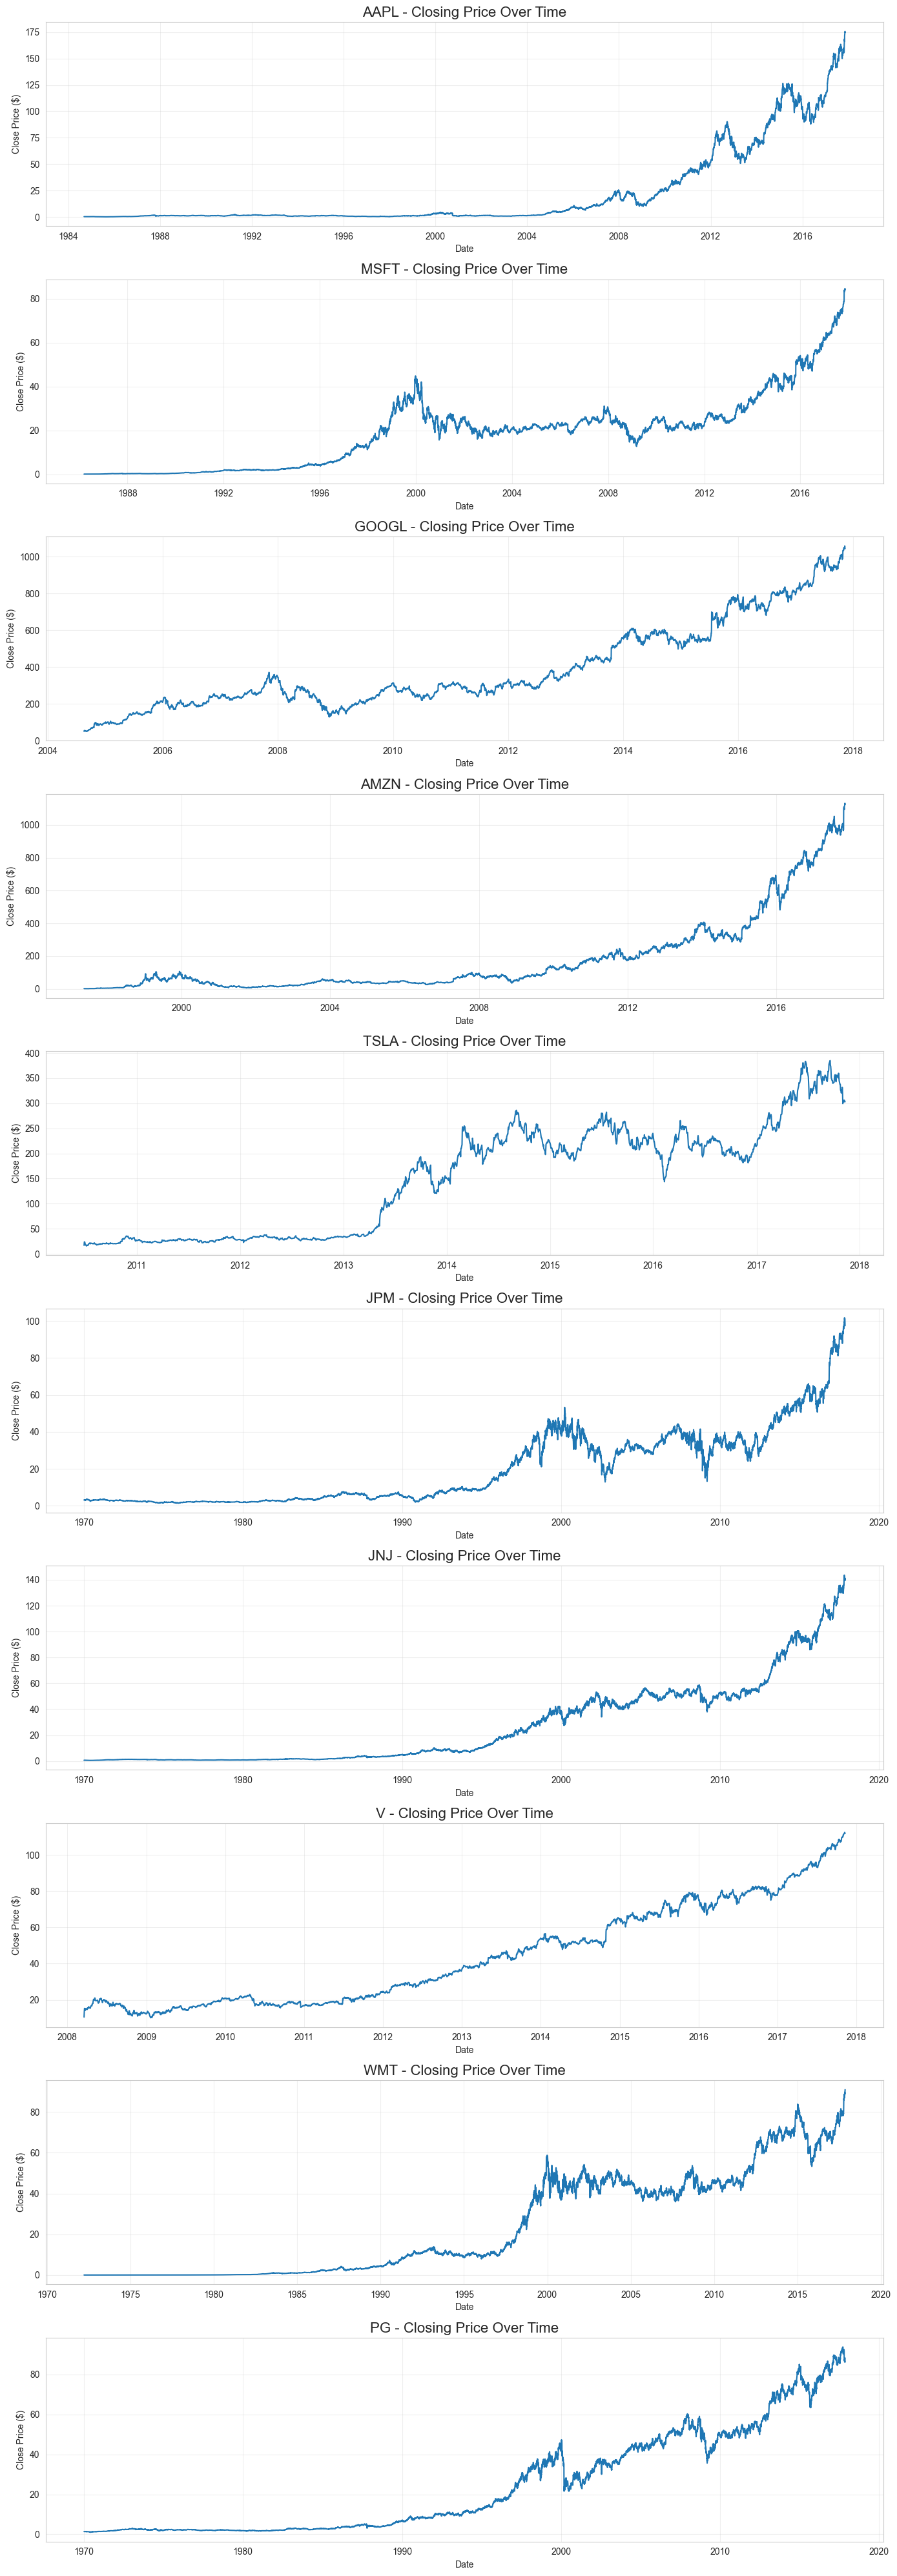

In [133]:
# Visualize closing prices over time
fig, axes = plt.subplots(len(stock_data), 1, figsize=(14, 4*len(stock_data)))
if len(stock_data) == 1:
    axes = [axes]

for idx, (stock, df) in enumerate(stock_data.items()):
    axes[idx].plot(df['Date'], df['Close'], linewidth=1.5)
    axes[idx].set_title(f'{stock.upper()} - Closing Price Over Time', fontsize=16)
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Close Price ($)')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [134]:
# Check for suspicious price changes (potential stock splits or data errors)
print("Checking for suspicious price changes (>50% in one day):\n")

for stock, df in stock_data.items():
    df['price_change_pct'] = df['Close'].pct_change() * 100
    suspicious = df[abs(df['price_change_pct']) > 50]
    
    if len(suspicious) > 0:
        print(f"{stock.upper()}: {len(suspicious)} suspicious price changes detected")
        display(suspicious[['Date', 'Close', 'price_change_pct']].head())
    else:
        print(f"{stock.upper()}: No suspicious price changes")

Checking for suspicious price changes (>50% in one day):

AAPL: 1 suspicious price changes detected


,Date,Close,price_change_pct
4059,2000-09-29,1.6496,-51.846338


MSFT: No suspicious price changes
GOOGL: No suspicious price changes
AMZN: No suspicious price changes
TSLA: No suspicious price changes
JPM: No suspicious price changes
JNJ: No suspicious price changes
V: No suspicious price changes
WMT: 2 suspicious price changes detected


,Date,Close,price_change_pct
619,1974-12-06,0.00821,-52.100350
627,1974-12-18,0.01714,108.769793


PG: No suspicious price changes


Based on steps 3 and 4, it seems that the Kaggle dataset was overall robust, with no missing/invalid values or duplicates. As for the outliers, they will be kept due to the volatility of stock markets, which should be accounted for in the model. Since the different stocks have different start and end dates, and many of the prices are zero/near-zero, only the shared date range between all 10 stocks will be used for the model.

### 5. Find Common Date Range

In [135]:
def get_common_date_range(stock_dfs):
    """
    Finds the common date range across all stocks.
    
    Returns:
        tuple: (common_start_date, common_end_date)
    """
    start_dates = [df['Date'].min() for df in stock_dfs.values()]
    end_dates = [df['Date'].max() for df in stock_dfs.values()]
    
    common_start = max(start_dates)  # Latest start date
    common_end = min(end_dates)      # Earliest end date
    
    return common_start, common_end

# Find common date range
common_start, common_end = get_common_date_range(stock_data)

print(f"Common date range: {common_start.date()} to {common_end.date()}")
print(f"Total days: {(common_end - common_start).days}")

# Filter all stocks to common date range
print("\nFiltering stocks to common date range:\n")
for stock, df in stock_data.items():
    original_len = len(df)
    stock_data[stock] = df[(df['Date'] >= common_start) & (df['Date'] <= common_end)].copy()
    new_len = len(stock_data[stock])
    print(f"{stock.upper():6s}: {original_len:5,d} → {new_len:5,d} rows (removed {original_len - new_len:,d})")

Common date range: 2010-06-28 to 2017-11-10
Total days: 2692

Filtering stocks to common date range:

AAPL  : 8,364 → 1,859 rows (removed 6,505)
MSFT  : 7,983 → 1,859 rows (removed 6,124)
GOOGL : 3,333 → 1,859 rows (removed 1,474)
AMZN  : 5,153 → 1,859 rows (removed 3,294)
TSLA  : 1,858 → 1,858 rows (removed 0)
JPM   : 12,074 → 1,859 rows (removed 10,215)
JNJ   : 12,074 → 1,859 rows (removed 10,215)
V     : 2,432 → 1,858 rows (removed 574)
WMT   : 11,443 → 1,859 rows (removed 9,584)
PG    : 12,075 → 1,859 rows (removed 10,216)


### 6. Create Labels (Up/Down Classification)
Binary labels to be used in the next notebook:

- 1 (Up): If today's closing price > yesterday's close price
- 0 (Down): Otherwise

In [136]:
def create_labels(df):
    df = df.copy()
    
    # Calculate price change
    df['Price_Change'] = df['Close'].diff()
    
    # Create the label for the current day (Up/Down)
    # and shift it backwards by 1 so that row x contains the label for x+1
    df['Label'] = (df['Price_Change'] > 0).astype(int).shift(-1)
    
    # The last row will be NaN so delete it
    df = df.dropna(subset=['Label'])
    
    # Convert back to int after shifting (shift converts to float)
    df['Label'] = df['Label'].astype(int)
    
    return df

# Create labels for all stocks
print("Creating Up/Down labels:\n")
for stock, df in stock_data.items():
    stock_data[stock] = create_labels(df)
    
    # Calculate label distribution
    label_dist = stock_data[stock]['Label'].value_counts(normalize=True)
    up_pct = label_dist.get(1, 0) * 100
    down_pct = label_dist.get(0, 0) * 100
    
    print(f"{stock.upper():5s}: Up: {up_pct:.1f}%, Down: {down_pct:.1f}%")

# Display sample with labels
print("\nSample data with labels:")
sample_stock = list(stock_data.keys())[0]
display(stock_data[sample_stock][['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Price_Change', 'Label']].head(10))

Creating Up/Down labels:

AAPL : Up: 52.5%, Down: 47.5%
MSFT : Up: 50.9%, Down: 49.1%
GOOGL: Up: 52.9%, Down: 47.1%
AMZN : Up: 52.7%, Down: 47.3%
TSLA : Up: 51.4%, Down: 48.6%
JPM  : Up: 51.7%, Down: 48.3%
JNJ  : Up: 52.0%, Down: 48.0%
V    : Up: 53.9%, Down: 46.1%
WMT  : Up: 53.4%, Down: 46.6%
PG   : Up: 51.2%, Down: 48.8%

Sample data with labels:


,Date,Open,High,Low,Close,Volume,Price_Change,Label
6505,2010-06-28,34.191,34.545,33.874,34.360,163083315,NaN,0
6506,2010-06-29,33.856,33.856,32.565,32.806,315472195,-1.554,0
6507,2010-06-30,32.877,33.036,32.020,32.212,205878957,-0.594,0
6508,2010-07-01,32.542,32.629,31.147,31.823,285057573,-0.389,0
6509,2010-07-02,32.103,32.132,31.144,31.623,193495389,-0.200,1
6510,2010-07-06,31.623,32.375,31.527,31.842,171357527,0.219,1
6511,2010-07-07,32.095,33.139,31.984,33.125,182036901,1.283,0
6512,2010-07-08,33.626,33.668,32.641,33.052,205559578,-0.073,1
6513,2010-07-09,32.899,33.282,32.678,33.247,120771554,0.195,0
6514,2010-07-12,33.108,33.532,32.637,32.950,156720330,-0.297,0


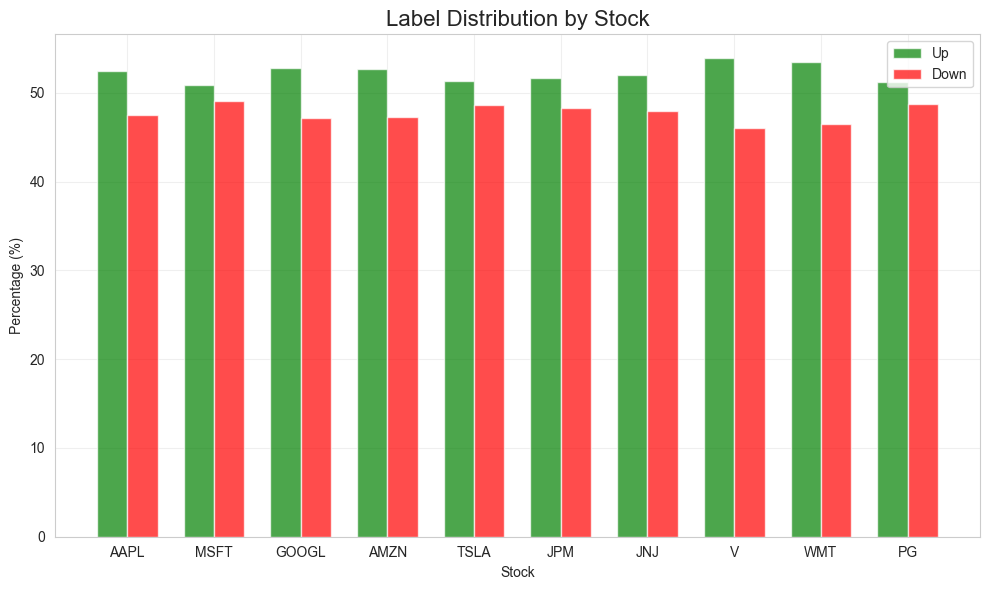

In [137]:
# Visualize label distribution
fig, ax = plt.subplots(figsize=(10, 6))

stocks_list = list(stock_data.keys())
up_percentages = []
down_percentages = []

for stock in stocks_list:
    label_dist = stock_data[stock]['Label'].value_counts(normalize=True)
    up_percentages.append(label_dist.get(1, 0) * 100)
    down_percentages.append(label_dist.get(0, 0) * 100)

x = np.arange(len(stocks_list))
width = 0.35

ax.bar(x - width/2, up_percentages, width, label='Up', color='green', alpha=0.7)
ax.bar(x + width/2, down_percentages, width, label='Down', color='red', alpha=0.7)

ax.set_xlabel('Stock')
ax.set_ylabel('Percentage (%)')
ax.set_title('Label Distribution by Stock', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels([s.upper() for s in stocks_list])
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 7. Combine all stocks into a single DataFrame

In [138]:
# Combine all stocks into one DataFrame
combined_df = pd.concat(stock_data.values(), ignore_index=True)

# Sort by stock and date
combined_df = combined_df.sort_values(['Stock', 'Date']).reset_index(drop=True)

# Print summarizing info
print(f"Combined dataset shape: {combined_df.shape}")
print(f"\nColumns: {list(combined_df.columns)}")
print(f"\nDate range: {combined_df['Date'].min().date()} to {combined_df['Date'].max().date()}")
print(f"Number of stocks: {combined_df['Stock'].nunique()}")
print(f"\nLabel distribution:")
print(combined_df['Label'].value_counts())
print(f"\nUp percentage: {combined_df['Label'].mean() * 100:.2f}%")

Combined dataset shape: (18578, 12)

Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt', 'Stock', 'Daily_Return', 'price_change_pct', 'Price_Change', 'Label']

Date range: 2010-06-28 to 2017-11-09
Number of stocks: 10

Label distribution:
Label
1    9707
0    8871
Name: count, dtype: int64

Up percentage: 52.25%


### 8. Train/Validation/Test Split

Using temporal splitting:

Train: First 70% of dates

Validation: Next 15% of dates

Test: Last 15% of dates

In [139]:
def temporal_split(df, train_ratio, val_ratio, test_ratio):
    """
    Split data temporally.
    
    Args:
        df: DataFrame with 'Date' column
        train_ratio: Proportion for training
        val_ratio: Proportion for validation
        test_ratio: Proportion for testing
    
    Returns:
        tuple: (train_df, val_df, test_df)
    """
    # Get unique dates and sort
    unique_dates = sorted(df['Date'].unique())
    n_dates = len(unique_dates)
    
    # Calculate split indices
    train_end_idx = int(n_dates * train_ratio)
    val_end_idx = train_end_idx + int(n_dates * val_ratio)
    
    # Get date cutoffs
    train_end_date = unique_dates[train_end_idx - 1]
    val_end_date = unique_dates[val_end_idx - 1]
    
    # Split data
    train_df = df[df['Date'] <= train_end_date].copy()
    val_df = df[(df['Date'] > train_end_date) & (df['Date'] <= val_end_date)].copy()
    test_df = df[df['Date'] > val_end_date].copy()
    
    return train_df, val_df, test_df

# Perform temporal split
train_df, val_df, test_df = temporal_split(combined_df, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

print(f"\nTrain Set:")
print(f"  Samples: {len(train_df):,} ({len(train_df)/len(combined_df)*100:.1f}%)")
print(f"  Date range: {train_df['Date'].min().date()} to {train_df['Date'].max().date()}")
print(f"  Up/Down: {train_df['Label'].value_counts().to_dict()}")

print(f"\nValidation Set:")
print(f"  Samples: {len(val_df):,} ({len(val_df)/len(combined_df)*100:.1f}%)")
print(f"  Date range: {val_df['Date'].min().date()} to {val_df['Date'].max().date()}")
print(f"  Up/Down: {val_df['Label'].value_counts().to_dict()}")

print(f"\nTest Set:")
print(f"  Samples: {len(test_df):,} ({len(test_df)/len(combined_df)*100:.1f}%)")
print(f"  Date range: {test_df['Date'].min().date()} to {test_df['Date'].max().date()}")
print(f"  Up/Down: {test_df['Label'].value_counts().to_dict()}")

print(f"\nTotal samples: {len(combined_df):,}")


Train Set:
  Samples: 12,998 (70.0%)
  Date range: 2010-06-28 to 2015-08-25
  Up/Down: {1: 6728, 0: 6270}

Validation Set:
  Samples: 2,780 (15.0%)
  Date range: 2015-08-26 to 2016-09-30
  Up/Down: {1: 1464, 0: 1316}

Test Set:
  Samples: 2,800 (15.1%)
  Date range: 2016-10-03 to 2017-11-09
  Up/Down: {1: 1515, 0: 1285}

Total samples: 18,578


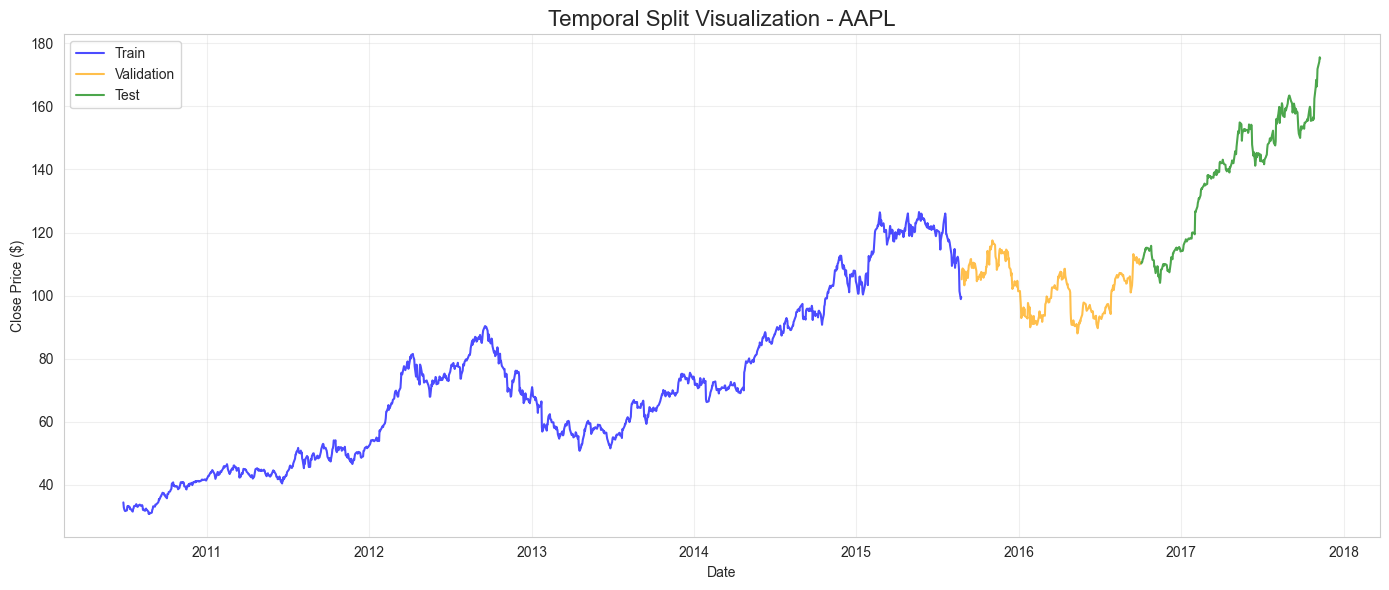

In [140]:
# Visualize the split
fig, ax = plt.subplots(figsize=(14, 6))

# Plot each set with different colors
sample_stock = combined_df['Stock'].iloc[0]
stock_train = train_df[train_df['Stock'] == sample_stock]
stock_val = val_df[val_df['Stock'] == sample_stock]
stock_test = test_df[test_df['Stock'] == sample_stock]

ax.plot(stock_train['Date'], stock_train['Close'], label='Train', color='blue', alpha=0.7)
ax.plot(stock_val['Date'], stock_val['Close'], label='Validation', color='orange', alpha=0.7)
ax.plot(stock_test['Date'], stock_test['Close'], label='Test', color='green', alpha=0.7)

ax.set_title(f'Temporal Split Visualization - {sample_stock}', fontsize=16)
ax.set_xlabel('Date')
ax.set_ylabel('Close Price ($)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 9. Feature Engineering

In [141]:
def add_technical_indicators(df):
    """
    Add technical indicators as features.
    """
    result_dfs = []
    
    for stock in df['Stock'].unique():
        stock_df = df[df['Stock'] == stock].copy().sort_values('Date')
        
        # Simple Moving Averages
        stock_df['SMA_5'] = stock_df['Close'].rolling(window=5).mean()
        stock_df['SMA_10'] = stock_df['Close'].rolling(window=10).mean()
        stock_df['SMA_20'] = stock_df['Close'].rolling(window=20).mean()
        
        # Exponential Moving Average
        stock_df['EMA_12'] = stock_df['Close'].ewm(span=12, adjust=False).mean()
        stock_df['EMA_26'] = stock_df['Close'].ewm(span=26, adjust=False).mean()

        # MACD (Moving Average Convergence Divergence)
        stock_df['MACD'] = stock_df['EMA_12'] - stock_df['EMA_26']
        stock_df['MACD_Signal'] = stock_df['MACD'].ewm(span=9, adjust=False).mean()
        
        # RSI (Relative Strength Index)
        delta = stock_df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        stock_df['RSI'] = 100 - (100 / (1 + rs))
        
        # Price momentum
        stock_df['Momentum_5'] = stock_df['Close'].pct_change(periods=5)
        stock_df['Momentum_10'] = stock_df['Close'].pct_change(periods=10)
        stock_df['Momentum_20'] = stock_df['Close'].pct_change(periods=20)

        # Volatility (standard deviation)
        stock_df['Volatility_5'] = stock_df['Close'].rolling(window=5).std()
        stock_df['Volatility_20'] = stock_df['Close'].rolling(window=20).std()
        
        # Volume indicators
        stock_df['Volume_SMA_5'] = stock_df['Volume'].rolling(window=5).mean()
        stock_df['Volume_Ratio'] = stock_df['Volume'] / (stock_df['Volume_SMA_5'] + 1e-10)
        
        # Price position relative to high/low
        stock_df['High_Low_Range'] = stock_df['High'] - stock_df['Low']
        stock_df['Close_Position'] = (stock_df['Close'] - stock_df['Low']) / (stock_df['High_Low_Range'] + 1e-10)
        
        # Add lagged features (yesterday's values)
        stock_df['Close_Lag1'] = stock_df['Close'].shift(1)
        stock_df['Close_Lag5'] = stock_df['Close'].shift(5)
        stock_df['Volume_Lag1'] = stock_df['Volume'].shift(1)
        
        # Price differences
        stock_df['Close_vs_SMA5'] = stock_df['Close'] - stock_df['SMA_5']
        stock_df['Close_vs_SMA20'] = stock_df['Close'] - stock_df['SMA_20']

        result_dfs.append(stock_df)
    
    return pd.concat(result_dfs, ignore_index=True)

# Apply to each split separately
print("Adding technical indicators to train set...")
train_df = add_technical_indicators(train_df)
train_df = train_df.dropna().reset_index(drop=True)

print("Adding technical indicators to validation set...")
val_df = add_technical_indicators(val_df)
val_df = val_df.dropna().reset_index(drop=True)

print("Adding technical indicators to test set...")
test_df = add_technical_indicators(test_df)
test_df = test_df.dropna().reset_index(drop=True)

print(f"\nTechnical indicators added to each split separately")
print(f"  Train samples: {len(train_df)}")
print(f"  Val samples: {len(val_df)}")
print(f"  Test samples: {len(test_df)}")

Adding technical indicators to train set...
Adding technical indicators to validation set...
Adding technical indicators to test set...

Technical indicators added to each split separately
  Train samples: 12798
  Val samples: 2580
  Test samples: 2600


### 10. Save processed data

In [142]:
# Save to csv files
train_path = PROCESSED_DATA_DIR / 'train.csv'
val_path = PROCESSED_DATA_DIR / 'val.csv'
test_path = PROCESSED_DATA_DIR / 'test.csv'

train_df.to_csv(train_path, index=False)
val_df.to_csv(val_path, index=False)
test_df.to_csv(test_path, index=False)

print(f"Train: {train_path}")
print(f"Val:   {val_path}")
print(f"Test:  {test_path}")
print("Data saved successfully\n")

Train: ..\data\processed\train.csv
Val:   ..\data\processed\val.csv
Test:  ..\data\processed\test.csv
Data saved successfully



### 11. Summary Statistics

In [143]:
print(f"Dataset Summary:")
print(f"  Stocks: {len(stock_data)} ({', '.join([s.upper() for s in stock_data.keys()])})")
print(f"  Date range: {combined_df['Date'].min().date()} to {combined_df['Date'].max().date()}")
print(f"  Total trading days: {len(combined_df['Date'].unique())}")
print(f"  Total samples: {len(combined_df):,}")

print(f"\nLabel Distribution:")
overall_up_pct = combined_df['Label'].mean() * 100
print(f"  Up (1): {combined_df['Label'].sum():,} ({overall_up_pct:.2f}%)")
print(f"  Down (0): {(combined_df['Label'] == 0).sum():,} ({100-overall_up_pct:.2f}%)")

print(f"\nData Splits:")
print(f"  Train: {len(train_df):,} samples ({len(train_df)/len(combined_df)*100:.1f}%)")
print(f"  Val:   {len(val_df):,} samples ({len(val_df)/len(combined_df)*100:.1f}%)")
print(f"  Test:  {len(test_df):,} samples ({len(test_df)/len(combined_df)*100:.1f}%)")

print(f"\nOutput files (train.csv, val.csv, test.csv) saved to: {PROCESSED_DATA_DIR}")
print(f"\n2_baseline_and_lstm_models.ipynb can now be run")

Dataset Summary:
  Stocks: 10 (AAPL, MSFT, GOOGL, AMZN, TSLA, JPM, JNJ, V, WMT, PG)
  Date range: 2010-06-28 to 2017-11-09
  Total trading days: 1858
  Total samples: 18,578

Label Distribution:
  Up (1): 9,707 (52.25%)
  Down (0): 8,871 (47.75%)

Data Splits:
  Train: 12,798 samples (68.9%)
  Val:   2,580 samples (13.9%)
  Test:  2,600 samples (14.0%)

Output files (train.csv, val.csv, test.csv) saved to: ..\data\processed

2_baseline_and_lstm_models.ipynb can now be run
